# T004 · Ligand-based screening: compound similarity

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Andrea Morger, 2017-2020, [Volkamer lab](https://volkamerlab.org/), Charité
- Franziska Fritz, CADD seminar, 2018, Charité/FU Berlin
- Yonghui Chen, 2019-2020, [Volkamer lab](https://volkamerlab.org/), Charité
- Dominique Sydow, 2018-2020, [Volkamer lab](https://volkamerlab.org/), Charité

__Talktorial T004__: This talktorial is part of the TeachOpenCADD pipeline described in the [first TeachOpenCADD paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x), comprising of **talktorials T001-T010**.

## Aim of this talktorial

In this talktorial, we get familiar with different approaches to encode (descriptors, fingerprints) and compare (similarity measures) molecules. Furthermore, we perform a virtual screening in the form of a similarity search for the EGFR inhibitor Gefitinib against our dataset of EGFR-tested molecules from the ChEMBL database filtered by Lipinski's rule of five (see **Talktorial T002**). 

### Contents in _Theory_

* Molecular similarity
* Molecular descriptors
* Molecular fingerprints
  * Substructure-based fingerprints
  * MACCS fingerprints
  * Morgan fingerprints and circular fingerprints
* Molecular similarity measures
  * Tanimoto coefficient
  * Dice coefficient
* Virtual screening
  * Virtual screening using similarity search
  * Enrichment plots

### Contents in _Practical_

* Import and draw molecules
* Calculate molecular descriptors
  * 1D molecular descriptors: Molecular weight
  * 2D molecular descriptors: MACCS fingerprint
  * 2D molecular descriptors: Morgan fingerprint
* Calculate molecular similarity
  * MACCS fingerprints: Tanimoto and Dice similarity
  * Morgan fingerprints: Tanimoto and Dice similarity
* Virtual screening using similarity search
  * Compare query molecule to all molecules in the data set
  * Distribution of similarity values
  * Visualize most similar molecules
  * Generate enrichment plots
  * Calculate enrichment factors

### References

* Review on "Molecular similarity in medicinal chemistry" ([<i>J. Med. Chem.</i> (2014), <b>57</b>, 3186-3204](http://pubs.acs.org/doi/abs/10.1021/jm401411z))
* [Morgan fingerprints](http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints) with `rdkit`
* Description of the extended-connectivity fingerprint ECFP ([<i>J. Chem. Inf. Model.</i> (2010), <b>50</b>,742-754](https://pubs.acs.org/doi/abs/10.1021/ci100050t))
* What is the chemical space?
([<i>ACS Chem. Neurosci.</i> (2012), <b>19</b>, 649-57](https://www.ncbi.nlm.nih.gov/pubmed/23019491))
* List of [molecular descriptors](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors) in `rdkit`
* List of [fingerprints](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-fingerprints) in `rdkit`
* Introduction to enrichment plots ([Applied Chemoinformatics, Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, (2018), **1**, 313-31](https://onlinelibrary.wiley.com/doi/10.1002/9783527806539.ch6h))

## Theory

### Molecular similarity 

Molecular similarity is a well known and often used concept in chemical informatics. Comparing molecules and their properties can be used in many different ways and help us to identify new molecules with desired properties and biological activity. 

The similar property principle (SPP) as well as the structure-activity relationship (SAR) approaches are based on the assumption that structurally similar molecules have similar properties and, thus, similar biological activity. In this context, virtual screening follows this idea to search for similar molecules in given a set of molecules with known binding affinity and to propose those as potentially new active molecules. 

### Molecular descriptors 

Similarity can be assessed in many different ways depending on the application (see [<i>J. Med. Chem.</i> (2014), <b>57</b>, 3186-3204</a>](http://pubs.acs.org/doi/abs/10.1021/jm401411z)): 

- 1D molecular descriptor: Solubility, logP, molecular weight, melting point.
  - Global descriptor: only one value represents the whole molecule
  - Usually do not contain enough information to be applied to machine learning (ML)
  - Can be added to 2D fingerprints to improve molecular encoding for ML
- 2D molecular descriptors: Molecular graphs, paths, fragments, atom environments
  - Detailed representation of individual parts of the molecule
  - Contains many features/bits per molecule called fingerprints
  - Very often used in similarity search and ML
- 3D molecular descriptors: Shape, stereochemistry
  - Less robust than 2D representations because of molecule flexibility (what is the "right" conformation of a molecule?)
    Biological similarity
  - Biological fingerprint, e.g. individual bits represent bioactivity measure against different targets
  - Independent of molecular structure
  - Requires experimental (or predicted) data

We already learned how to calculate 1D physicochemical parameters, such as the molecular weight and logP in **Talktorial T002**. 
More information about these [descriptors](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors) in the `rdkit` documentation.  

In the following, we focus on the definition of 2D molecular descriptors. Due to their, mostly, uniqueness per molecule, these descriptors are also called fingerprints.

### Molecular fingerprints

#### Substructure-based fingerprints

Molecular fingerprints are a computational representation of molecules that encode chemical and molecular features in the form of bitstrings, bitvectors or arrays. Each bit corresponds to a predefined molecular feature or environment, where "1" represents the presence and "0" the absence of a feature. Note that some implementations are count-based. Thus, they count how often a specific feature is present.

There are multiple ways to design fingerprints.
Here, we introduce MACCS keys and Morgan fingerprint as two commonly used 2D fingerprints. 
As can be seen in the `rdkit` documentation on [fingerprints](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-fingerprints), `rdkit` also offers multiple alternate fingerprints. 

#### MACCS fingerprints

Molecular ACCess System 
(MACCS) fingerprints, also termed MACCS structural keys, consist of 166 predefined structural fragments. Each position queries the presence or absence of one particular structural fragment or key. 
The individual keys were empirically defined by medicinal chemists and are simple to use and interpret (`rdkit` documentation on [MACCS keys](http://rdkit.org/Python_Docs/rdkit.Chem.MACCSkeys-module.html)).

![Figure 1](images/maccs_fp.png)

*Figure 1*: Illustration of MACCS fingerprint (figure by Andrea Morger).

#### Morgan fingerprints and circular fingerprints 

This family of fingerprints is based on the Morgan algorithm. 
The bits correspond to the circular environments of each atom in a molecule. 
The number of neighboring bonds and atoms to consider is set by the radius. 
Also the length of the bit string can be defined, a longer bit string will be modded to the desired length. 
Therefore, the Morgan fingerprint is not limited to a certain number of bits. 
More about the [Morgan fingerprint](http://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints) can be found in the 
`rdkit` documentation. 
Extended connectivity fingerprints (ECFP) are also commonly used fingerprints that are derived using a variant of the Morgan algorithm, see [<i>J. Chem. Inf. Model.</i> (2010), <b>50</b>,742-754](https://pubs.acs.org/doi/abs/10.1021/ci100050t) for further information. 

![Figure 2](images/morgan_fp.png)

*Figure 2*: Illustration of the Morgan circular fingerprint (figure by Andrea Morger).

### Molecular similarity measures 

Once the descriptors/fingerprints are calculated, they can be compared to assess the similarity between two molecules. Molecular similarity can be quantified with a number of different similarity coefficients, two common similarity measures are the Tanimoto and Dice index ([<i>J. Med. Chem.</i> (2014), <b>57</b>, 3186-3204](http://pubs.acs.org/doi/abs/10.1021/jm401411z)).

#### Tanimoto coefficient

$$T _{c}(A,B) = \frac{c}{a+b-c}$$

- a: number of features present in molecule A 
- b: number of features present in molecule B 
- c: number of features shared by molecules A and B

#### Dice coefficient

$$D_{c}(A,B) = \frac{c}{\frac{1}{2}(a+b)}$$

- a: number of features present in molecule A
- b: number of features present in molecule B 
- c: number of features shared by molecules A and B

The similarity measures usually consider the number of positive bits (1's) present in either fingerprint and the number of positive bits that both have in common. 
Dice similarity usually returns higher values than Tanimoto similarity because of their denominators:

$$\frac{c}{a+b-c} \leq \frac{c}{\frac{1}{2}(a+b)}$$

### Virtual screening 

The challenge in early stages of drug discovery is to narrow down a set of small molecules (molecules) from the large existing chemical space that are potentially binding to the target under investigation. Note that this chemical space is vast: Small molecules can be made of 10<sup>20</sup> combinations of chemical moieties ([<i>ACS Chem. Neurosci.</i> (2012), <b>19</b>, 649-57](https://www.ncbi.nlm.nih.gov/pubmed/23019491)). 

Since experimental high-throughput screening (HTS) for the activity of all those small molecules against the target of interest is cost and time intensive, computer-aided methods are invoked to propose a focused list of small molecules to be tested. This process is called virtual (high-throughput) screening: a large library of small molecules is filtered by rules and/or patterns, in order to identify those small molecules that are most likely to bind a target under investigation.

#### Virtual screening using similarity search

Comparing a set of novel molecules against a (or several) known active molecule(s) to find the most similar ones can be used as a simple way of virtual screening. 
Given the similar property principle, we can assume that the most similar molecules, e.g. to a known inhibitor, also have similar effects. Requirements for a similarity search are the following (as discussed in detail above):

* A representation that encodes chemical/molecular features
* A potential weighting of features (optional)
* A similarity measurement

A similarity search can be performed by calculating the similarity between one molecule and all molecules in a specific dataset. Ranking the molecules of the dataset by their similarity coefficient yields the most similar molecules at the top.

#### Enrichment plots

Enrichment plots are used to validate virtual screening results, which display the ratio of active molecules detected in the top x% of the ranked list, i.e.: 

* the ratio of top-ranked molecules (x-axis) from the whole dataset vs. 
* the ratio of active molecules (y-axis) from the whole dataset.

![Figure 3](images/enrichment_plot.png)

*Figure 3*: Example of enrichment plot for virtual screening results.

## Practical

In the first part of this practical section, we will use `rdkit` to encode molecules (molecular fingerprints) and compare them in order to calculate their similarity (molecular similarity measures), as discussed in the theory section above.

In the second part, we will use these encoding and comparison techniques to conduct a similarity search (virtual screening): 
We use the known EGFR inhibitor Gefitinib as query and search for similar molecules in our data set of molecules tested on EGFR, which we collected from the ChEMBL database in **Talktorial T001** and filtered by Lipinski's rule of five in **Talktorial T002**.

### Import and draw molecules

First, we define and draw eight example molecules, which we will encode and compare later on. 
The molecules in SMILES format are converted to `rdkit` molecule objects and visualized with the `Draw` module in `rdkit`.

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys,
    rdFingerprintGenerator,
)

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

Let's define some molecule examples.

In [3]:
# Molecules in SMILES format
molecule_smiles = [
    "CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C",
    "C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl",
    "CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC",
    "C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl",
    "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C",
    "CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O",
]

# List of molecule names
molecule_names = [
    "Doxycycline",
    "Amoxicilline",
    "Furosemide",
    "Glycol dilaurate",
    "Hydrochlorothiazide",
    "Isotretinoin",
    "Tetracycline",
    "Hemi-cycline D",
]

Generate a `DataFrame` for these molecules and add their ROMol objects.

,smiles,name,ROMol
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,

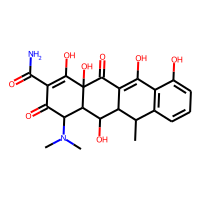
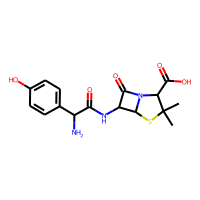

In [4]:
molecules = pd.DataFrame({"smiles": molecule_smiles, "name": molecule_names})
PandasTools.AddMoleculeColumnToFrame(molecules, smilesCol="smiles")
# Show first 2 molecules
molecules.head(2)

Visualize all molecules.

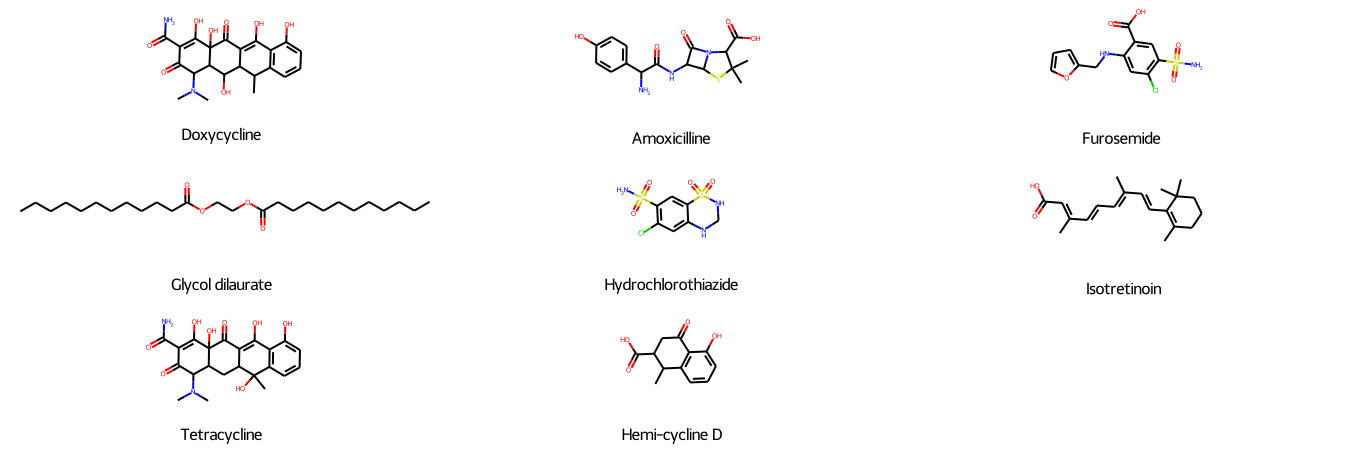

In [5]:
Draw.MolsToGridImage(
    molecules["ROMol"].to_list(),
    molsPerRow=3,
    subImgSize=(450, 150),
    legends=molecules["name"].to_list(),
)

### Calculate molecular descriptors

We extract and generate 1D and 2D molecular descriptors to compare our molecules. 
For 2D descriptors, different types of fingerprints are generated to be used later for the calculation of the molecular similarity.

#### 1D molecular descriptors: Molecular weight

We calculate the molecular weight of our example structures.

In [6]:
# Note -- we use pandas apply function to apply the MolWt function
# to all ROMol objects in the DataFrame
molecules["molecule_weight"] = molecules.ROMol.apply(Descriptors.MolWt)
# Sort molecules by molecular weight
molecules.sort_values(["molecule_weight"], ascending=False, inplace=True)

We draw our molecular structures with their similar molecular weight for visual comparison: Is the molecular weight a feasible descriptor for molecule similarity?

In [7]:
# Show only molecule names and molecular weights
molecules[["smiles", "name", "molecule_weight"]]
# NBVAL_CHECK_OUTPUT

,smiles,name,molecule_weight
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,444.440
6,CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Tetracycline,444.440
3,CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC,Glycol dilaurate,426.682
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,365.411
2,C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl,Furosemide,330.749
5,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,Isotretinoin,300.442
4,C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl,Hydrochlorothiazide,297.745
7,CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O,Hemi-cycline D,220.224


We draw the molecules with their molecular weight.

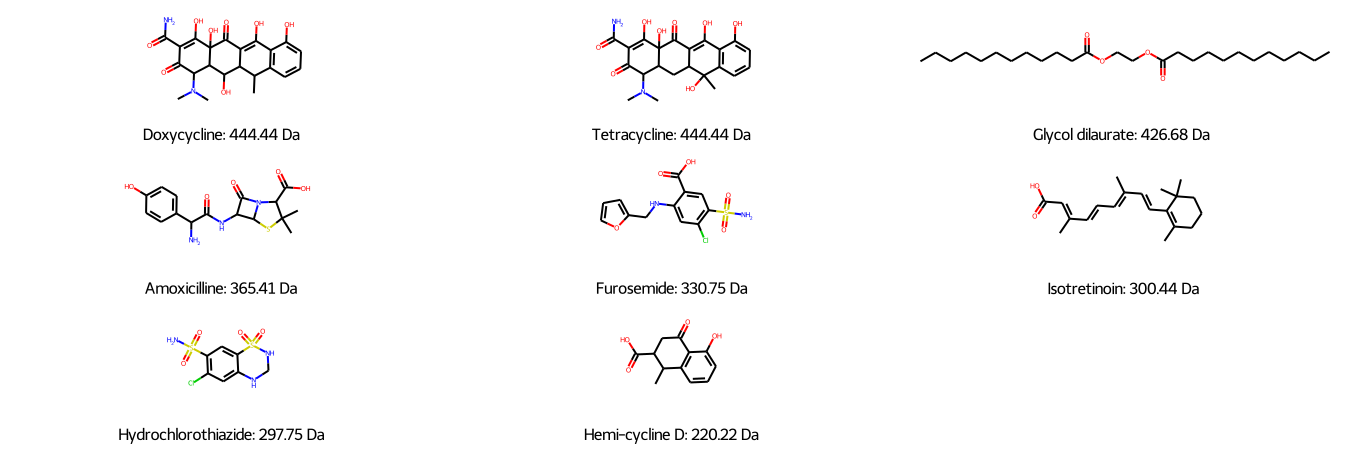

In [8]:
Draw.MolsToGridImage(
    molecules["ROMol"],
    legends=[
        f"{molecule['name']}: {molecule['molecule_weight']:.2f} Da"
        for index, molecule in molecules.iterrows()
    ],
    subImgSize=(450, 150),
    molsPerRow=3,
)

As we can see, molecules with similar molecular weight can have a similar structure (e.g. Doxycycline/Tetracycline), however they can also have a similar number of atoms in completely different arrangements (e.g. Doxycycline/Glycol dilaurate or Hydrochlorothiazide/Isotretinoin).

In order to account for more detailed properties of a molecule, we now take a look at 2D molecular descriptors.

#### 2D molecular descriptors: MACCS fingerprint

__Example molecule__: Let's use an example molecule from our `DataFrame`.

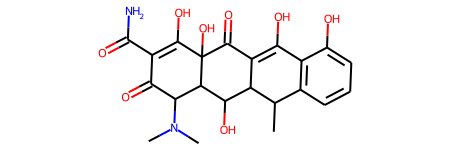

In [9]:
molecule = molecules["ROMol"][0]
molecule

MACCS fingerprints can be easily generated using `rdkit`.

In [10]:
maccs_fp = MACCSkeys.GenMACCSKeys(molecule)

As explicit bitvectors are not human-readable, we will further transform them to bitstrings.

In [11]:
# NBVAL_CHECK_OUTPUT
maccs_fp.ToBitString()

'00000000000000000000000000100000000000000000000000100110000000000010000010101000000011100100110101010100010000101100010000100001000101001001111111101111101011111111110'

__Applied to all molecules__: Add MACCS fingerprints for all molecules to the `DataFrame`.

In [12]:
molecules["maccs"] = molecules.ROMol.apply(MACCSkeys.GenMACCSKeys)

#### 2D molecular descriptors: Morgan fingerprint

We can also calculate the circular Morgan fingerprints with `rdkit`. The Morgan fingerprint can be calculated either as int or bit vector. By default the radius is 2 and the vector is 2048 long. 

__Example molecule__: Let's use again with our example molecule.

Generate the Morgan fingerprint _as int vector_.

In [13]:
circular_int_fp = rdFingerprintGenerator.GetCountFPs([molecule])[0]
circular_int_fp

In [14]:
# NBVAL_CHECK_OUTPUT
print(f"Print non-zero elements:\n{circular_int_fp.GetNonzeroElements()}")

Print non-zero elements:
{45: 1, 118: 1, 140: 1, 163: 1, 276: 1, 303: 1, 309: 1, 314: 2, 371: 1, 438: 1, 525: 1, 557: 1, 650: 3, 673: 1, 699: 1, 807: 6, 824: 1, 829: 1, 881: 1, 1009: 1, 1019: 5, 1027: 1, 1039: 1, 1057: 3, 1060: 1, 1061: 1, 1070: 1, 1082: 1, 1088: 1, 1119: 1, 1154: 1, 1163: 2, 1171: 1, 1257: 1, 1296: 1, 1309: 1, 1341: 1, 1380: 9, 1389: 1, 1457: 1, 1471: 1, 1487: 1, 1582: 1, 1602: 3, 1607: 1, 1630: 1, 1747: 1, 1750: 2, 1831: 1, 1833: 1, 1857: 1, 1873: 3, 1917: 1, 1932: 1, 2000: 1, 2029: 1}


Generate the Morgan fingerprint _as bit vector_.

In [15]:
# Note that the function takes a list as input parameter
# (even if we only want to pass one molecule)
circular_bit_fp = rdFingerprintGenerator.GetFPs([molecule])[0]
circular_bit_fp

In [16]:
# NBVAL_CHECK_OUTPUT
print(f"Print top 400 fingerprint bits:\n{circular_bit_fp.ToBitString()[:400]}")

Print top 400 fingerprint bits:
0000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000010000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000001000001000010000000000000000000000000000000000000000000000000000000010000000000000000000000000000


__Applied to all molecules__: Add Morgan fingerprints (as bit vector) for all molecules to the `DataFrame`.

In [17]:
molecules["morgan"] = rdFingerprintGenerator.GetFPs(molecules["ROMol"].tolist())

### Calculate molecular similarity

In the following, we will apply two similarity measures, i.e. **Tanimoto** and **Dice**, to our two fingerprint types, i.e. **MACCS** and **Morgan** fingerprints.

__Example molecule pair__: Compare two MACCS fingerprints with the Tanimoto similarity.

In [18]:
# Example molecules
molecule1 = molecules["ROMol"][0]
molecule2 = molecules["ROMol"][1]

# Example fingerprints
maccs_fp1 = MACCSkeys.GenMACCSKeys(molecule1)
maccs_fp2 = MACCSkeys.GenMACCSKeys(molecule2)

Calculate the Tanimoto coefficient _between two different molecules_.

In [19]:
# NBVAL_CHECK_OUTPUT
DataStructs.TanimotoSimilarity(maccs_fp1, maccs_fp2)

0.5909090909090909

Calculate Tanimoto coefficient _between the same molecule_.

In [20]:
# NBVAL_CHECK_OUTPUT
DataStructs.TanimotoSimilarity(maccs_fp1, maccs_fp1)

1.0

In the following, we want to compare a query molecule with our molecule list. 
Therefore, we use `BulkTanimotoSimilarity` and `BulkDiceSimilarity` from `rdkit` that calculate the similarity of a query fingerprint with a list of fingerprints, based on a similarity measure. We will investigate all combinations of MACCS/Morgan fingerprint comparisons based on the Tanimoto/Dice similarity measure.

#### MACCS fingerprints: Tanimoto similarity and Dice similarity

Add the Tanimoto and Dice similarities between MACCS fingerprints to the `DataFrame`.

In [21]:
# Define molecule query and list
molecule_query = molecules["maccs"][0]
molecule_list = molecules["maccs"].to_list()
# Calculate similarty values between query and list elements
molecules["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_maccs"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

Sort the `DataFrame` by the Tanimoto similarity of the MACCS fingerprints (show only name and similarity columns!).

In [22]:
preview = molecules.sort_values(["tanimoto_maccs"], ascending=False).reset_index()
preview[["name", "tanimoto_maccs", "dice_maccs"]]
# NBVAL_CHECK_OUTPUT

,name,tanimoto_maccs,dice_maccs
0,Doxycycline,1.000000,1.000000
1,Tetracycline,0.928571,0.962963
2,Amoxicilline,0.590909,0.742857
3,Hemi-cycline D,0.403509,0.575000
4,Furosemide,0.321839,0.486957
5,Hydrochlorothiazide,0.306818,0.469565
6,Isotretinoin,0.288136,0.447368
7,Glycol dilaurate,0.149254,0.259740


__Note__: Tanimoto and Dice similarity measures by definition result in the same ranking of molecules, with higher values for the Dice similarity (see Tanimoto and Dice equations in the theory section of this talktorial).

Draw molecules ranked by the Tanimoto similarity of MACCS fingerprints.

In [23]:
def draw_ranked_molecules(molecules, sort_by_column):
    """
    Draw molecules sorted by a given column.

    Parameters
    ----------
    molecules : pandas.DataFrame
        Molecules (with "ROMol" and "name" columns and a column to sort by.
    sort_by_column : str
        Name of the column used to sort the molecules by.

    Returns
    -------
    Draw.MolsToGridImage
        2D visualization of sorted molecules.
    """

    molecules_sorted = molecules.sort_values([sort_by_column], ascending=False).reset_index()
    return Draw.MolsToGridImage(
        molecules_sorted["ROMol"],
        legends=[
            f"#{index+1} {molecule['name']}, similarity={molecule[sort_by_column]:.2f}"
            for index, molecule in molecules_sorted.iterrows()
        ],
        molsPerRow=3,
        subImgSize=(450, 150),
    )

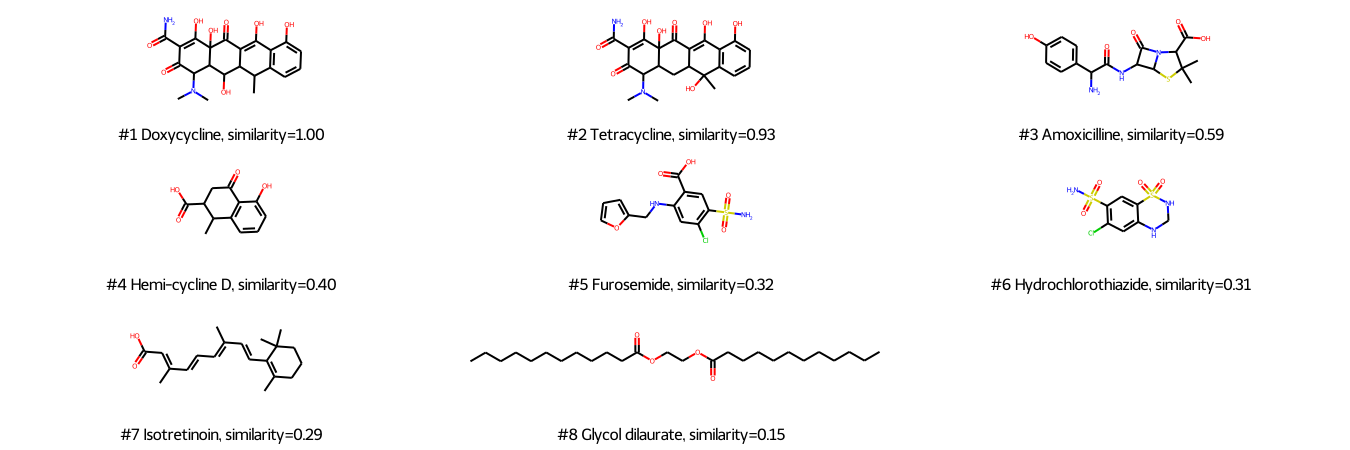

In [24]:
draw_ranked_molecules(molecules, "tanimoto_maccs")

With MACCS fingerprints, Tetracycline is the most similar molecule (high score), followed by Amoxicilline. In contrast to the 1D descriptor molecular weight, the linear molecule Glycol dilaurate is recognized as dissimilar (last rank).

#### Morgan fingerprints: Tanimoto similarity and Dice similarity

Add the Tanimoto and Dice similarities between the Morgan fingerprints to the `DataFrame`.

In [25]:
# Define molecule query and list
molecule_query = molecules["morgan"][0]
molecule_list = molecules["morgan"].to_list()
# Calculate similarty values between query and list elements
molecules["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_morgan"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

Sort the `DataFrame` by the Tanimoto similarity of the Morgan fingerprints.

In [26]:
preview = molecules.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
preview[["name", "tanimoto_morgan", "dice_morgan", "tanimoto_maccs", "dice_maccs"]]
# NBVAL_CHECK_OUTPUT

,name,tanimoto_morgan,dice_morgan,tanimoto_maccs,dice_maccs
0,Doxycycline,1.000000,1.000000,1.000000,1.000000
1,Tetracycline,0.534247,0.696429,0.928571,0.962963
2,Hemi-cycline D,0.308824,0.471910,0.403509,0.575000
3,Amoxicilline,0.144444,0.252427,0.590909,0.742857
4,Furosemide,0.098901,0.180000,0.321839,0.486957
5,Isotretinoin,0.067416,0.126316,0.288136,0.447368
6,Hydrochlorothiazide,0.058824,0.111111,0.306818,0.469565
7,Glycol dilaurate,0.054795,0.103896,0.149254,0.259740


Draw molecules ranked by the Tanimoto similarities of Morgan fingerprints.

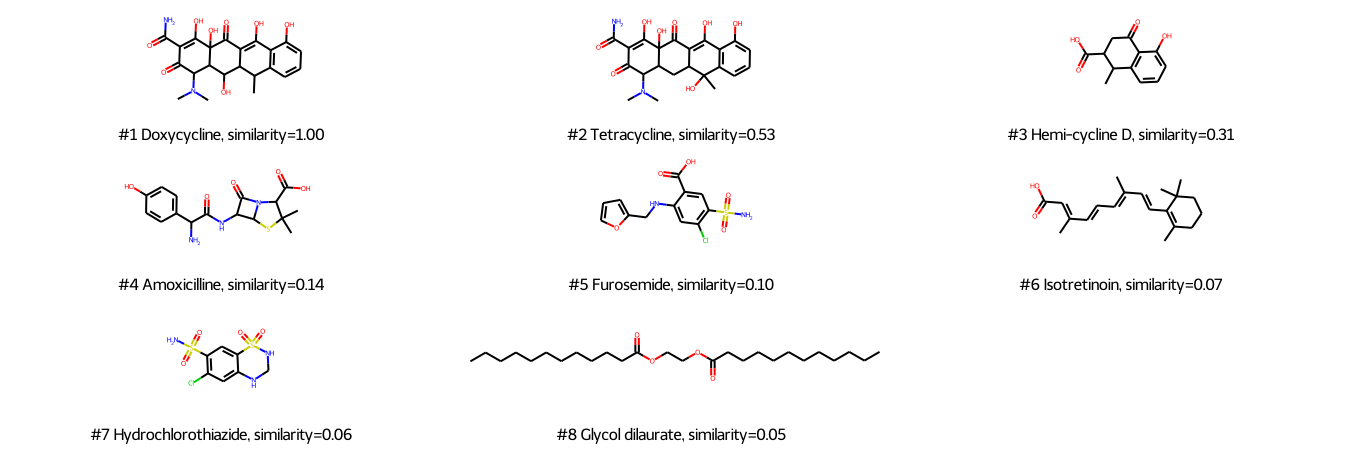

In [27]:
draw_ranked_molecules(molecules, "tanimoto_morgan")

We compare the Tanimoto similarities based on MACCS and Morgan fingerprints. Therefore, we plot the Tanimoto similarities based on Morgen fingerprints vs. the Tanimoto simlarities based on MACCS fingerprints.

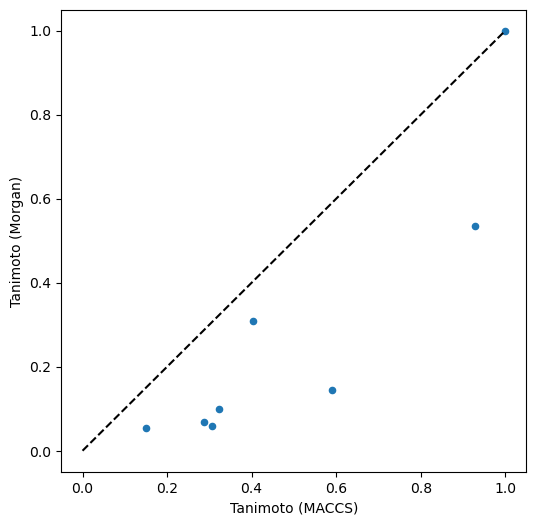

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))
molecules.plot("tanimoto_maccs", "tanimoto_morgan", kind="scatter", ax=ax)
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Tanimoto (MACCS)")
ax.set_ylabel("Tanimoto (Morgan)")
fig;

Usage of different fingerprints (here: MACCS and Morgan fingerprints) results in different similarity values (here: Tanimoto similarity) and thus potentially also in different rankings of molecule similarity as shown here. 

Morgan fingerprints also recognize Tetracycline as the most similar molecule to Doxycycline (but with a lower score), and Clycol dilaurate as most dissimilar. However, ranked second is Hemi-cycline D, a structural part of cyclines - possibly because of the atom environment-based algorithm of Morgan fingerprints (whereas MACCS fingerprints rather ask for the occurrence of certain properties). 

### Virtual screening using similarity search

Now that we have learned how to calculate fingerprints and the similarity between them, we can apply this knowledge to a similarity search of a query molecule against a full data set of molecules. 

We use the known EGFR inhibitor Gefitinib as query and search for similar molecules in our data set of molecules tested on EGFR, which we collected from the ChEMBL database in **Talktorial T001** and filtered by Lipinski's rule of five in **Talktorial T002**.

#### Compare query molecule to all molecules in the data set

We import molecules from a *csv* file containing the filtered EGFR-tested molecules from the ChEMBL database as provided by **Talktorial T002**. Given one query molecule (here Gefitinib), we screen that data set for similar molecules.

__Dataset__: Import data from the _csv_ file containing molecules in the SMILES format.

In [29]:
molecule_dataset = pd.read_csv(
    HERE / "../T002_compound_adme/data/EGFR_compounds_lipinski.csv",
    usecols=["molecule_chembl_id", "smiles", "pIC50"],
)
print(f"Number of molecules in dataset: {len(molecule_dataset)}")
molecule_dataset.head(5)

Number of molecules in dataset: 4635


,molecule_chembl_id,smiles,pIC50
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910


__Query__: For the query molecule Gefitinib, generate the `ROMol` object from the query molecule's SMILES.

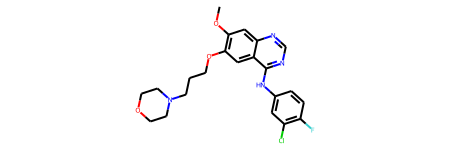

In [30]:
query = Chem.MolFromSmiles("COC1=C(OCCCN2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C=C3)=NC=NC2=C1")
query

Generate MACCS and Morgan fingerprints for the query molecule.

In [31]:
maccs_fp_query = MACCSkeys.GenMACCSKeys(query)
circular_fp_query = rdFingerprintGenerator.GetCountFPs([query])[0]

Generate MACCS and Morgan fingerprints for all molecules in our dataset.

In [32]:
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")
circular_fp_list = rdFingerprintGenerator.GetCountFPs(molecule_dataset["ROMol"].tolist())
maccs_fp_list = molecule_dataset["ROMol"].apply(MACCSkeys.GenMACCSKeys).tolist()

Calculate the Tanimoto similarity between the query molecule (Gefitinib) and all molecules our dataset (using MACCS and Morgan fingerprints).

In [33]:
molecule_dataset["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(
    maccs_fp_query, maccs_fp_list
)
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(
    circular_fp_query, circular_fp_list
)

Calculate Dice similarity for query molecule (Gefitinib) and all molecules in file (MACCS, Morgan).

In [34]:
molecule_dataset["dice_maccs"] = DataStructs.BulkDiceSimilarity(maccs_fp_query, maccs_fp_list)
molecule_dataset["dice_morgan"] = DataStructs.BulkDiceSimilarity(
    circular_fp_query, circular_fp_list
)

In [35]:
# NBVAL_CHECK_OUTPUT
molecule_dataset[
    ["smiles", "tanimoto_maccs", "tanimoto_morgan", "dice_maccs", "dice_morgan"]
].head(5)

,smiles,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,0.409836,0.324786,0.581395,0.490323
1,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,0.666667,0.445455,0.800000,0.616352
2,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,0.484375,0.327434,0.652632,0.493333
3,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,0.384615,0.345133,0.555556,0.513158
4,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,0.428571,0.333333,0.600000,0.500000


,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0.409836,0.324786,0.581395,0.490323
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0.666667,0.445455,0.800000,0.616352
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0.484375,0.327434,0.652632,0.493333

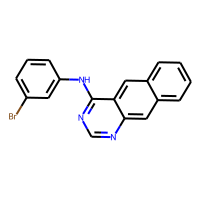
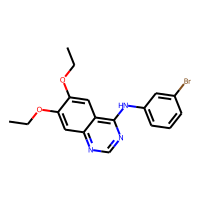
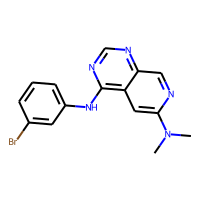

In [36]:
# Show all columns
molecule_dataset.head(3)

#### Distribution of similarity values

As mentioned in the theory section, compared for the same fingerprint (e.g. MACCS fingerprints), Tanimoto similarity values are lower than Dice similarity values.
Also, comparing two different fingerprints (e.g. MACCS and Morgan fingerprints), the similarity measure values (e.g. Tanimotot similarity) vary. 

We can have a look at the distributions by plotting histograms.

First, we can plot distribution of Tanimoto similarity of MACCS fingerprints.

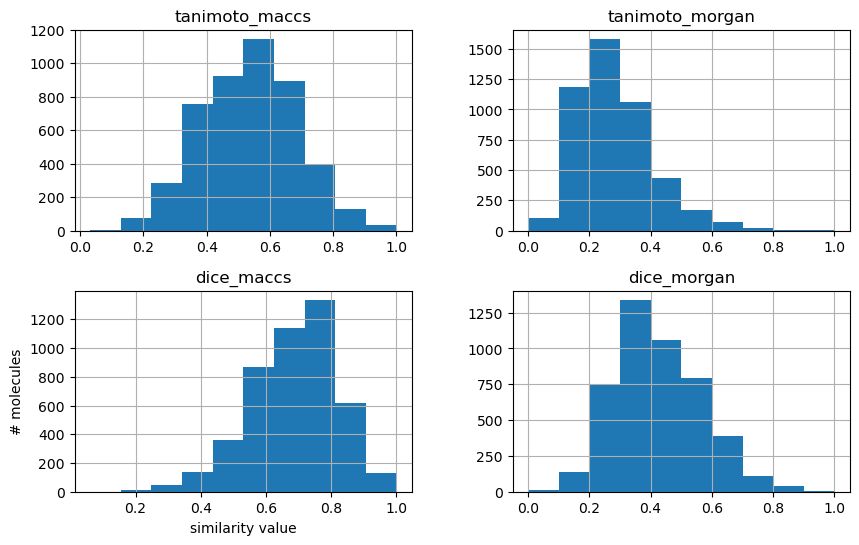

In [37]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
molecule_dataset.hist(["tanimoto_maccs"], ax=axes[0, 0])
molecule_dataset.hist(["tanimoto_morgan"], ax=axes[0, 1])
molecule_dataset.hist(["dice_maccs"], ax=axes[1, 0])
molecule_dataset.hist(["dice_morgan"], ax=axes[1, 1])
axes[1, 0].set_xlabel("similarity value")
axes[1, 0].set_ylabel("# molecules")
fig;

Second, we can compare similarities here. This time, let's directly compare Tanimoto and Dice similarities for the two fingerprints.

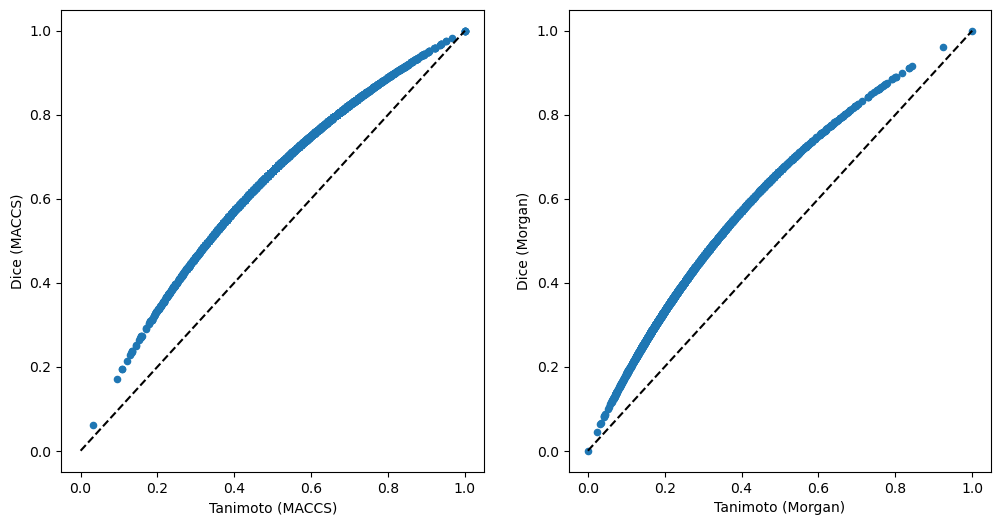

In [38]:
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

molecule_dataset.plot("tanimoto_maccs", "dice_maccs", kind="scatter", ax=axes[0])
axes[0].plot([0, 1], [0, 1], "k--")
axes[0].set_xlabel("Tanimoto (MACCS)")
axes[0].set_ylabel("Dice (MACCS)")

molecule_dataset.plot("tanimoto_morgan", "dice_morgan", kind="scatter", ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_xlabel("Tanimoto (Morgan)")
axes[1].set_ylabel("Dice (Morgan)")

fig;

Similarity distributions are important to interpret similarity values, e.g. a value of 0.6 needs to be evaluated differently for MACCS or Morgan fingerprints, as well as Tanimoto or Dice similarities.

#### Visualize most similar molecules

We visually inspect the structure of Gefitinib in comparison to the most similar molecules in our ranking, including the information about their bioactivity (pIC50 derived from the ChEMBL database in **Talktorial T001**).

Here, we sort the `DataFrame` by the Tanimoto similarity based on Morgan fingerprints.

,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
2639,CHEMBL939,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1,6.288193,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",1.000000,1.000000,1.000000,1.000000
880,CHEMBL14699,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCN1CCOCC1,8.000000,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",1.000000,0.923913,1.000000,0.960452
1747,CHEMBL299672,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCCC1,7.148742,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0.919355,0.843750,0.957983,0.915254

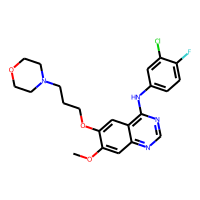
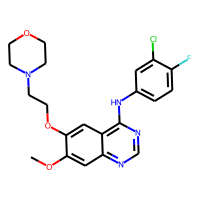
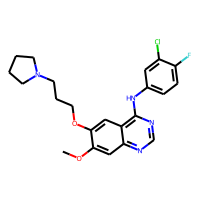

In [39]:
molecule_dataset.sort_values(["tanimoto_morgan"], ascending=False).head(3)

Show the query and its most similar molecules alongside the molecules' bioactivities.

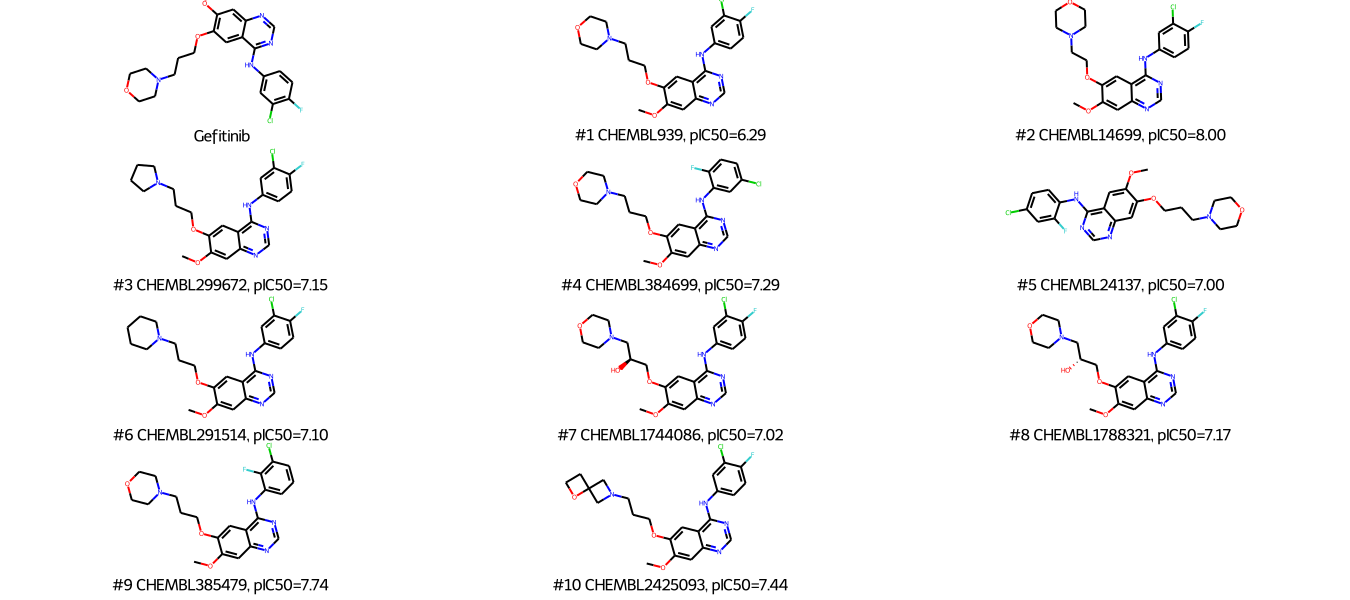

In [40]:
top_n_molecules = 10
top_molecules = molecule_dataset.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
top_molecules = top_molecules[:top_n_molecules]
legends = [
    f"#{index+1} {molecule['molecule_chembl_id']}, pIC50={molecule['pIC50']:.2f}"
    for index, molecule in top_molecules.iterrows()
]
Chem.Draw.MolsToGridImage(
    mols=[query] + top_molecules["ROMol"].tolist(),
    legends=(["Gefitinib"] + legends),
    molsPerRow=3,
    subImgSize=(450, 150),
)

The top ranked molecules for Gefitinib are Gefitinib entries (rank 1 and 2) in our dataset, followed by alterations of Gefitinib, e.g. different benzole substitution patterns. 
Note: ChEMBL contains the complete structure-activity relationship analysis for Gefitinib (being a well-studied molecule), therefore it is not surprising to have that many Gefitinib-like molecules in our dataset.

We now check how well the similarity search is able to distinguish between active and inactive molecules based on our dataset. Therefore, we use the bioactivity values, which we collected from ChEMBL for each molecule (bioactivity against EGFR) in **Talktorial T001**.

#### Generate enrichment plots

In order to validate our virtual screening and see the ratio of detected active molecules, we generate an enrichment plot. 

__Enrichment plots__ show 

* the ratio of top-ranked molecules (x-axis) from the whole dataset vs. 
* the ratio of active molecules (y-axis) from the whole dataset. 

We compare the Tanimoto similarity for MACCS and Morgan fingerprints. 

In order to decide whether we treat a molecule as active or inactive, we apply the commonly used pIC50 cutoff value of 6.3. Although there are several suggestions ranging from an pIC50 cutoff values of 5 to 7 in the literature or even to define an exclusion range, we think this cutoff is reasonable. 
The same cutoff will be used for machine learning in **Talktorial T010**.

,molecule_chembl_id,smiles,pIC50,ROMol,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0.409836,0.324786,0.581395,0.490323
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0.666667,0.445455,0.800000,0.616352
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",0.484375,0.327434,0.652632,0.493333

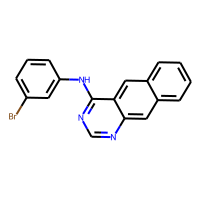
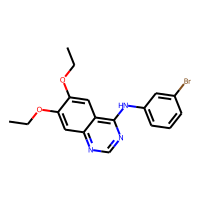
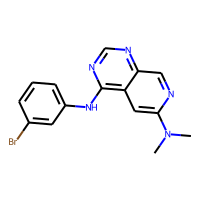

In [41]:
molecule_dataset.head(3)

In [42]:
def get_enrichment_data(molecules, similarity_measure, pic50_cutoff):
    """
    Calculates x and y values for enrichment plot:
        x - % ranked dataset
        y - % true actives identified

    Parameters
    ----------
    molecules : pandas.DataFrame
        Molecules with similarity values to a query molecule.
    similarity_measure : str
        Column name which will be used to sort the DataFrame．
    pic50_cutoff : float
        pIC50 cutoff value used to discriminate active and inactive molecules.

    Returns
    -------
    pandas.DataFrame
        Enrichment data: Percentage of ranked dataset by similarity vs. percentage of identified true actives.
    """

    # Get number of molecules in data set
    molecules_all = len(molecules)

    # Get number of active molecules in data set
    actives_all = sum(molecules["pIC50"] >= pic50_cutoff)

    # Initialize a list that will hold the counter for actives and molecules while iterating through our dataset
    actives_counter_list = []

    # Initialize counter for actives
    actives_counter = 0

    # Note: Data must be ranked for enrichment plots:
    # Sort molecules by selected similarity measure
    molecules.sort_values([similarity_measure], ascending=False, inplace=True)

    # Iterate over the ranked dataset and check each molecule if active (by checking bioactivity)
    for value in molecules["pIC50"]:
        if value >= pic50_cutoff:
            actives_counter += 1
        actives_counter_list.append(actives_counter)

    # Transform number of molecules into % ranked dataset
    molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]

    # Transform number of actives into % true actives identified
    actives_percentage_list = [i / actives_all for i in actives_counter_list]

    # Generate DataFrame with x and y values as well as label
    enrichment = pd.DataFrame(
        {
            "% ranked dataset": molecules_percentage_list,
            "% true actives identified": actives_percentage_list,
        }
    )

    return enrichment

Set the pIC50 cutoff used to discriminate active and inactive molecules... 

In [43]:
pic50_cutoff = 6.3

...and get the enrichment for MACCS and Morgan fingerprints (using the Tanimoto similarity).

In [44]:
similarity_measures = ["tanimoto_maccs", "tanimoto_morgan"]
enrichment_data = {
    similarity_measure: get_enrichment_data(molecule_dataset, similarity_measure, pic50_cutoff)
    for similarity_measure in similarity_measures
}

Show example enrichment data.

In [45]:
# NBVAL_CHECK_OUTPUT
enrichment_data["tanimoto_maccs"].head()

,% ranked dataset,% true actives identified
0,0.000216,0.00038
1,0.000431,0.00038
2,0.000647,0.00076
3,0.000863,0.00114
4,0.001079,0.00152


Plot the enrichment data next to the optimal and random enrichment curve!

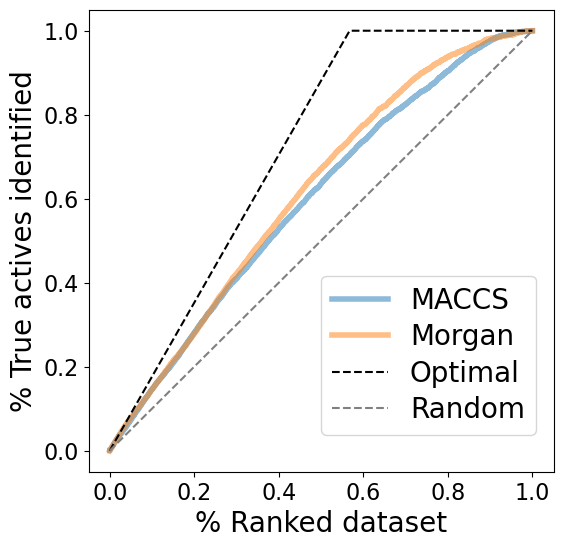

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))

fontsize = 20

# Plot enrichment data
for similarity_measure, enrichment in enrichment_data.items():
    ax = enrichment.plot(
        ax=ax,
        x="% ranked dataset",
        y="% true actives identified",
        label=similarity_measure,
        alpha=0.5,
        linewidth=4,
    )
ax.set_ylabel("% True actives identified", size=fontsize)
ax.set_xlabel("% Ranked dataset", size=fontsize)

# Plot optimal curve: Ratio of actives in dataset
ratio_actives = sum(molecule_dataset["pIC50"] >= pic50_cutoff) / len(molecule_dataset)
ax.plot(
    [0, ratio_actives, 1],
    [0, 1, 1],
    label="Optimal curve",
    color="black",
    linestyle="--",
)

# Plot random curve
ax.plot([0, 1], [0, 1], label="Random curve", color="grey", linestyle="--")

plt.tick_params(labelsize=16)
plt.legend(
    labels=["MACCS", "Morgan", "Optimal", "Random"],
    loc=(0.5, 0.08),
    fontsize=fontsize,
    labelspacing=0.3,
)

# Save plot -- use bbox_inches to include text boxes
plt.savefig(
    DATA / "enrichment_plot.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

plt.show()

The enrichment plots show a slightly better performance for fingerprint comparison based on Morgan fingerprints than based on MACCS fingerprints.

#### Calculate enrichment factors

The (experimental) __enrichment factor (EF)__ is used to access a methods success by a single number rather than a plot. The idea is to determine the percentage of active molecules in the top x% (e.g. 5%) of ranked molecules, as defined by the following helper function.

In [47]:
def calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff):
    """
    Get the experimental enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    enrichment : pd.DataFrame
        Enrichment data: Percentage of ranked dataset by similarity vs. percentage of
        identified true actives.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Experimental enrichment factor.
    """

    # Keep only molecules that meet the cutoff
    enrichment = enrichment[
        enrichment["% ranked dataset"] <= ranked_dataset_percentage_cutoff / 100
    ]
    # Get highest percentage of actives and the corresponding percentage of actives
    highest_enrichment = enrichment.iloc[-1]
    enrichment_factor = round(100 * float(highest_enrichment["% true actives identified"]), 1)
    return enrichment_factor

This helper function calculates the random enrichment of active molecules in the top x% of ranked molecules (__random enrichment factor__).

In [48]:
def calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff):
    """
    Get the random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.

    Returns
    -------
    float
        Random enrichment factor.
    """

    enrichment_factor_random = round(float(ranked_dataset_percentage_cutoff), 1)
    return enrichment_factor_random

And this helper function calculates the optimal enrichment of active molecules in the top x% of ranked molecules (__optimal enrichment factor__). The random and optimal enrichment factors are needed to judge how good the experimental enrichment factor for a method is.

In [49]:
def calculate_enrichment_factor_optimal(molecules, ranked_dataset_percentage_cutoff, pic50_cutoff):
    """
    Get the optimal random enrichment factor for a given percentage of the ranked dataset.

    Parameters
    ----------
    molecules : pandas.DataFrame
        the DataFrame with all the molecules and pIC50.
    ranked_dataset_percentage_cutoff : float or int
        Percentage of ranked dataset to be included in enrichment factor calculation.
    activity_cutoff: float
        pIC50 cutoff value used to discriminate active and inactive molecules

    Returns
    -------
    float
        Optimal enrichment factor.
    """

    ratio = sum(molecules["pIC50"] >= pic50_cutoff) / len(molecules) * 100
    if ranked_dataset_percentage_cutoff <= ratio:
        enrichment_factor_optimal = round(100 / ratio * ranked_dataset_percentage_cutoff, 1)
    else:
        enrichment_factor_optimal = 100.0
    return enrichment_factor_optimal

We are ready to calculate the experimental enrichment factor (EF) for 5% of ranked dataset... 

In [50]:
ranked_dataset_percentage_cutoff = 5

In [51]:
for similarity_measure, enrichment in enrichment_data.items():
    enrichment_factor = calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff)
    print(
        f"Experimental EF for {ranked_dataset_percentage_cutoff}% of ranked dataset ({similarity_measure}): {enrichment_factor}%"
    )
# NBVAL_CHECK_OUTPUT

Experimental EF for 5% of ranked dataset (tanimoto_maccs): 7.2%
Experimental EF for 5% of ranked dataset (tanimoto_morgan): 7.8%


... and we can compare it to the random and optimal enrichment factor.

In [52]:
enrichment_factor_random = calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff)
print(
    f"Random EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_random}%"
)
enrichment_factor_optimal = calculate_enrichment_factor_optimal(
    molecule_dataset, ranked_dataset_percentage_cutoff, pic50_cutoff
)
print(
    f"Optimal EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_optimal}%"
)
# NBVAL_CHECK_OUTPUT

Random EF for 5% of ranked dataset: 5.0%
Optimal EF for 5% of ranked dataset: 8.8%


## Discussion

We have learned how to use fingerprints and similarity measures to compare a query molecule with a dataset of molecules and rank the molecule by similarity. This approach is an example for virtual screening of molecules.
Enrichment plots and enrichment factors can be used to assess the performance. 

A drawback of a similarity search with molecular fingerprints is that it is based on molecular similarity and thus does not yield any novel structures. Another challenge when working with molecular similarity are so-called activity cliffs, i.e. a small change in a functional group of a molecule may initiate a jump in bioactivity. 

## Quiz

* What could be a starting point to circumvent activity cliffs?
* What are the advantages and disadvantages of MACCS and Morgan fingerprints compared to each other fingerprints?
* How can you explain the different orders in the similarity dataframe depending on the fingerprint used?